
# quickdraw-doodle-recognition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [221]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import dill as pickle

In [3]:
PATH = '/home/borowis/s3'

In [4]:
ls {PATH}

sample_submission.csv  test/  train/


In [110]:
BASE_SIZE = 256                  # image size
NUM_SAMPLES_PER_CLASS = 10       # set to -1 for all images

# csv data to images

In [6]:
df = pd.read_csv(f'{PATH}/train/airplane.csv')

In [9]:
len(df); df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",6622904974311424,False,2017-03-06 21:39:04.690130,airplane
2,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
3,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5643224746033152,True,2017-03-10 00:35:17.531970,airplane
4,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6670046841536512,True,2017-01-23 18:11:11.658170,airplane


In [92]:
def draw_cv2(raw_strokes, size=256, lw=2, time_color=True):
    colors = [(255, 0, 0) , (255, 255, 0),  (128, 255, 0),  (0, 255, 0), (0, 255, 128), (0, 255, 255), 
              (0, 128, 255), (0, 0, 255), (128, 0, 255), (255, 0, 255)]
    img = np.zeros((BASE_SIZE, BASE_SIZE, 3), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = colors[min(t, len(colors)-1)]
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw, lineType=cv2.LINE_4)
    img = img.astype(np.float32)/255
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

In [24]:
img = draw_cv2(json.loads(df.iloc[0]['drawing']))
#plt.imshow(img)
#plt.savefig(f'{PATH}/train/images/{df.iloc[0]["key_id"]}.png')
cv2.imwrite(f'{PATH}/train/images/{df.iloc[0]["key_id"]}.webp', img)

True

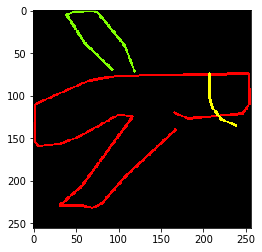

In [93]:
#plt.imshow(plt.imread(f'{PATH}/train/images/{df.iloc[0]["key_id"]}.webp'))
plt.imshow(df.iloc[:5]['drawing'].apply(json.loads).apply(draw_cv2)[0])

In [198]:
X_train = None
Y_train = None
vals1 = np.stack(df.iloc[:5]['drawing'].apply(json.loads).apply(draw_cv2).values)
vals2 = np.stack(df.iloc[5:10]['drawing'].apply(json.loads).apply(draw_cv2).values)
if X_train is not None:
    X_train = np.concatenate((X_train, vals1))
else:
    X_train = vals1
    
if X_train is not None:
    X_train = np.concatenate((X_train, vals2))
else:
    X_train = vals2
    
(X_val, X_train) = split_by_idx(get_cv_idxs(10, seed=None), X_train)[0]

In [217]:
categories = [fileName.replace('.csv', '') for fileName in os.listdir(f'{PATH}/train') if ('.csv' in fileName)]
categories2idx = {c:idx for idx, c in enumerate(categories)}
idx2category = {idx:c for idx, c in enumerate(categories)}

In [226]:
pickle.dump(categories2idx, open(f'{PATH}/cat2idx.pkl', 'wb'))
pickle.dump(idx2category, open(f'{PATH}/idx2cat.pkl', 'wb'))

In [ ]:
X_val = X_train = Y_val = Y_train = None
for category in categories:
    df = pd.read_csv(f'{PATH}/train/{category}.csv')
    idxs = np.random.permutation(len(df))[:NUM_SAMPLES_PER_CLASS]
    
    y = np.full(NUM_SAMPLES_PER_CLASS, categories2idx[category])
    imgs = np.stack(df.iloc[idxs]['drawing'].apply(json.loads).apply(draw_cv2).values)
    ((imgs_val, imgs_train), (y_val, y_train)) = split_by_idx(get_cv_idxs(NUM_SAMPLES_PER_CLASS, seed=None), imgs, y)
    
    if X_train is None:
        X_val, X_train = imgs_val, imgs_train
        Y_val, Y_train = y_val, y_train
    else:
        X_val, X_train = np.concatenate((X_val, imgs_val)), np.concatenate((X_train, imgs_train))
        Y_val, Y_train = np.concatenate((Y_val, y_val)), np.concatenate((Y_train, y_train))

# multi label

In [5]:
metrics = [f2]
f_model = resnet34

In [6]:
label_csv = f'{PATH}/train_v2.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [7]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, transforms_top_down, max_zoom = 1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms = tfms, suffix = '.jpg', 
                                        val_idxs = val_idxs, test_name = 'test-jpg')

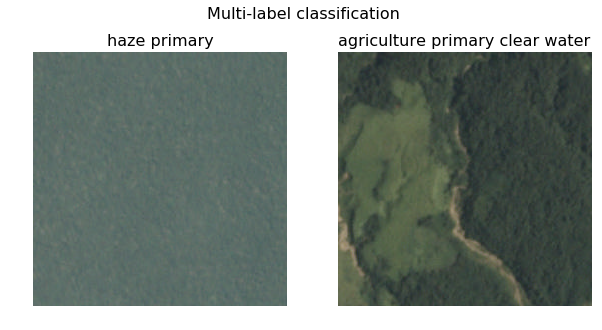

In [25]:
list_paths = [f'{PATH}/train-jpg/train_0.jpg', f'{PATH}/train-jpg/train_1.jpg']
titles = ['haze primary', 'agriculture primary clear water']
plots_from_files(list_paths, titles = titles, maintitle = "Multi-label classification")

In [29]:
data = get_data(256)
x, y = next(iter(data.val_dl))

In [32]:
y, y.shape

(tensor([[1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 torch.Size([64, 17]))

In [33]:
list(zip(data.classes, y[0]))

[('agriculture', tensor(1., device='cuda:0')),
 ('artisinal_mine', tensor(0., device='cuda:0')),
 ('bare_ground', tensor(0., device='cuda:0')),
 ('blooming', tensor(0., device='cuda:0')),
 ('blow_down', tensor(0., device='cuda:0')),
 ('clear', tensor(1., device='cuda:0')),
 ('cloudy', tensor(0., device='cuda:0')),
 ('conventional_mine', tensor(0., device='cuda:0')),
 ('cultivation', tensor(0., device='cuda:0')),
 ('habitation', tensor(0., device='cuda:0')),
 ('haze', tensor(0., device='cuda:0')),
 ('partly_cloudy', tensor(0., device='cuda:0')),
 ('primary', tensor(1., device='cuda:0')),
 ('road', tensor(0., device='cuda:0')),
 ('selective_logging', tensor(0., device='cuda:0')),
 ('slash_burn', tensor(0., device='cuda:0')),
 ('water', tensor(1., device='cuda:0'))]

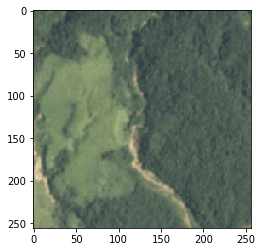

In [34]:
plt.imshow(data.val_ds.denorm(to_np(x))[0] * 1.4)

## size 64

In [8]:
data = get_data(64)

In [9]:
data = data.resize(int(64*1.3), 'tmp')

In [10]:
learn = ConvLearner.pretrained(f_model, data, metrics = metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.217808   0.289875   0.829447  



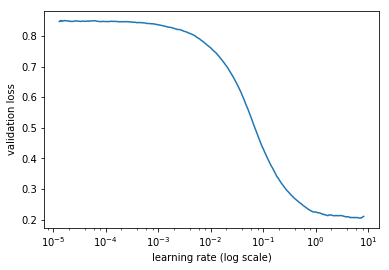

In [13]:
lrf = learn.lr_find()
learn.sched.plot()

In [11]:
lr = 0.2

In [15]:
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   f2                          
    0      0.148586   0.132767   0.883217  
    1      0.143447   0.127722   0.887822                    
    2      0.134575   0.125105   0.891185                    
    3      0.139888   0.125518   0.889785                    
    4      0.136921   0.123426   0.892397                    
    5      0.13365    0.121311   0.895296                    
    6      0.130139   0.121563   0.894305                    



[0.12156299452876662, 0.89430526688528289]

In [12]:
lrs = np.array([lr / 9, lr / 3, lr])
learn.unfreeze()

In [17]:
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   f2                          
    0      0.123122   0.10885    0.90848   
    1      0.117439   0.105398   0.910827                    
    2      0.104933   0.100027   0.916188                    
    3      0.110297   0.104712   0.910897                    
    4      0.105774   0.099827   0.914601                    
    5      0.102372   0.096354   0.919566                     
    6      0.098592   0.096043   0.919165                     



[0.096043156076353817, 0.91916517263195885]

In [13]:
# learn.save('64')
learn.load('64')

In [ ]:
learn.sched.plot_loss()

## size 128

In [14]:
learn.set_data(get_data(128))
learn.freeze()
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   f2                                      
    0      0.099892   0.093863   0.920407  
    1      0.10107    0.09243    0.921161                                
    2      0.097319   0.092072   0.921106                                
    3      0.094566   0.091442   0.923161                                
    4      0.094501   0.091194   0.922312                                
    5      0.09327    0.090379   0.923341                                
    6      0.092802   0.090635   0.922729                                



[0.09063529569455471, 0.9227290682590451]

In [16]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   f2                                      
    0      0.093225   0.086826   0.926825  
    1      0.095709   0.085982   0.927744                                
    2      0.088472   0.084504   0.928993                                
    3      0.091159   0.08678    0.929802                                
    4      0.087554   0.084805   0.92912                                 
    5      0.085065   0.083372   0.931035                                
    6      0.082379   0.083013   0.931326                                



[0.083013470492074345, 0.93132622188051062]

In [15]:
# learn.save('128')
learn.load('128')

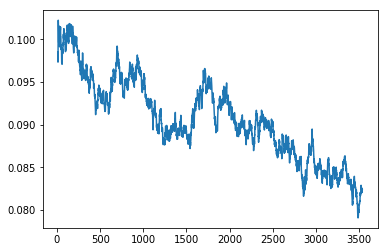

In [18]:
learn.sched.plot_loss()

## size 256

In [16]:
learn.set_data(get_data(256))
learn.freeze()
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   f2                                      
    0      0.090933   0.087154   0.926851  
    1      0.089951   0.086012   0.928473                                
    2      0.089689   0.085723   0.928939                                
    3      0.087564   0.085838   0.928821                                
    4      0.086923   0.085737   0.92867                                 
    5      0.090448   0.085465   0.928639                                
    6      0.089076   0.085192   0.928966                                



[0.085191652992391675, 0.9289659909249891]

In [20]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   f2                                      
    0      0.084256   0.082361   0.932677  
    1      0.088619   0.082841   0.932305                                
    2      0.08163    0.081028   0.933675                                
    3      0.085515   0.082613   0.932701                                
    4      0.082955   0.082618   0.931859                                
    5      0.079482   0.080515   0.933858                                
    6      0.078534   0.080544   0.934229                                



[0.080543803823553833, 0.93422885791195753]

In [17]:
# learn.save('256')
learn.load('256')

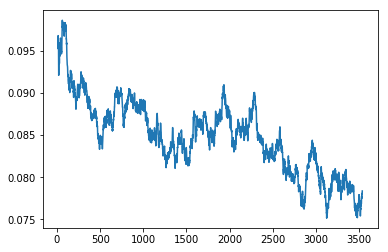

In [37]:
learn.sched.plot_loss()

## end

In [18]:
log_preds, y = learn.TTA()

In [19]:
preds = np.mean(log_preds, axis = 0)
f2(preds, y)

0.93212612794568717

## submission

In [20]:
val = learn.predict()

In [21]:
f2(val,data.val_y)

0.93079289872979598

In [36]:
log_preds = learn.TTA(is_test=True)

In [40]:
th = opt_th(preds, y); th

0.18000000000000002

In [43]:
preds = np.mean(log_preds[0], axis=0)
cls = np.array(data.classes)
res = np.array([" ".join(cls[(np.where(pp > th))]) for pp in preds])

In [53]:
fnames = [f[9:-4] for f in data.test_dl.dataset.fnames]

In [55]:
outp = pd.DataFrame({'image_name': fnames, 'tags': res})
outp.head()

,image_name,tags
0,test_10415,clear primary
1,test_37142,clear primary
2,test_7910,clear primary
3,file_2971,clear primary road water
4,file_19072,agriculture clear cultivation habitation prima...
